<a href="https://colab.research.google.com/github/adlathifa/Customer_Segmentation_Analysis/blob/main/Mall_Customer_Segmentation_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.express as px
import seaborn as sns

### Data Preparation

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
file_path = '/content/drive/MyDrive/Project/Mall_Customers.csv'

df = pd.read_csv(file_path)
df.head()

,CustomerID,Gender,Age,Annual_Income(k$),Spending_Score(1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CustomerID             200 non-null    int64 
 1   Gender                 200 non-null    object
 2   Age                    200 non-null    int64 
 3   Annual_Income(k$)      200 non-null    int64 
 4   Spending_Score(1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [10]:
#Check missing values
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual_Income(k$),0
Spending_Score(1-100),0


### Exploratory Data Analysis

In [11]:
#Create age group
age_bins = [18, 21, 31, 41, 100]
age_labels = ['18-20', '21-30', '31-40', 'above 41']

df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels= age_labels, right=False)

In [12]:
# Age Distribution
age_counts = df['Age_Group'].value_counts().sort_index()

fig = px.pie(age_counts,
    names = age_counts.index,
    values = age_counts.values,
    color_discrete_sequence = px.colors.sequential.RdBu)
fig.update_traces(textposition = 'inside', textinfo = 'percent+label',
    marker = dict(line=dict(color='white', width=2)))
fig.update_layout(title='Customer Age Group Distribution')
fig.show()

- Customer mostly are older age (above 31)

In [13]:
# Gender Distribution
gender_counts = df.Gender.value_counts()

fig = px.pie(gender_counts,
             names = gender_counts.index,
             values = gender_counts.values,
             color_discrete_sequence = px.colors.qualitative.Vivid)
fig.update_traces(textposition='inside', textinfo='percent+label',
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.update_layout(title = 'Gender Distribution')
fig.show()

- Female is dominated population (56%) compared with male (44%)

In [14]:
# create income group
bins = [15, 45.5, 76, 106.5, 137]
labels =['15k-<45,5k', '45,5k-<76k', '76k-<106,5k', '106,5k-137k']

df['Income_Group'] = pd.cut(df['Annual_Income(k$)'], bins=bins, labels=labels, include_lowest=True)

In [15]:
# Income Distribution
income_counts = df.Income_Group.value_counts()

fig = px.pie(income_counts,
             names = income_counts.index,
             values = income_counts.values,
             color_discrete_sequence = px.colors.qualitative.Vivid)
fig.update_traces(textposition='inside', textinfo='percent+label',
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.update_layout(title = 'Income Distribution')
fig.show()

- The customers income is skewed towards lower to lower-mid range ($15k - < $76k)

In [16]:
#age vs income
grouped_income = df.groupby(['Age_Group', 'Income_Group'], observed=True).size().reset_index(name='Counts')

fig = px.bar(grouped_income, x='Age_Group', y='Counts',color='Income_Group',
             barmode='group', labels={'Counts': 'Counts'}, title='Income Group per Age Group',
             color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_layout(xaxis_title='Age Group', yaxis_title='Counts')
fig.show()

In [17]:
# Create custom bins for Spending Score
bins = [0, 25, 50, 75, 100]
labels = ['0-25','26-50','51-75','76-100']

df['Spending_Score'] = pd.cut(df['Spending_Score(1-100)'], bins=bins, labels=labels, include_lowest=True)

In [18]:
#age vs spending score
grouped_spending = df.groupby(['Age_Group', 'Spending_Score'], observed=True).size().reset_index(name='Counts')

fig = px.bar(grouped_spending, x='Age_Group', y='Counts', color='Spending_Score',
             barmode='group', labels={'Counts': 'Counts'}, title='Spending Score per Age Group',
             color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_layout(xaxis_title='Age Group', yaxis_title='Counts')
fig.show()

### Feature Engineering

In [19]:
# Removing data that should not be included in the cluster
df_x = df.copy().drop(['CustomerID', 'Age', 'Annual_Income(k$)', 'Spending_Score(1-100)'], axis=1)

In [20]:
# Creating a dictionary to replace values in the 'Gender' column
gender_mapping = {'Male': 1, 'Female': 0}
df_x['Gender'] = df_x['Gender'].map(gender_mapping)

In [21]:
# Creating a dictionary to replace values in the 'Age_Group' column
age_mapping = {'18-20': 1, '21-30': 2, '31-40': 3, 'above 41': 4}
df_x['Age_Group'] = df_x['Age_Group'].map(age_mapping)

In [22]:
# Creating a dictionary to replace values in the 'Income_Group' column
df_x['Income_Group'] = df_x['Income_Group'].astype(str)

income_mapping = {'15k-<45,5k': 1, '45,5k-<76k': 2, '76k-<106,5k': 3, '106,5k-137k':4}
df_x['Income_Group'] = df_x['Income_Group'].map(income_mapping)

In [23]:
# Creating a dictionary to replace values in the 'Spending_Score' column
df_x['Spending_Score'] = df_x['Spending_Score'].astype(str)

spending_mapping = {'0-25': 1,'26-50': 2,'51-75': 3,'76-100': 4}
df_x['Spending_Score'] = df_x['Spending_Score'].map(spending_mapping)

In [24]:
df_x

,Gender,Age_Group,Income_Group,Spending_Score
0,1,1,1,2
1,1,2,1,4
2,0,1,1,1
3,0,2,1,4
4,0,3,1,2
...,...,...,...,...
195,0,3,4,4
196,0,4,4,2
197,1,3,4,3
198,1,3,4,1


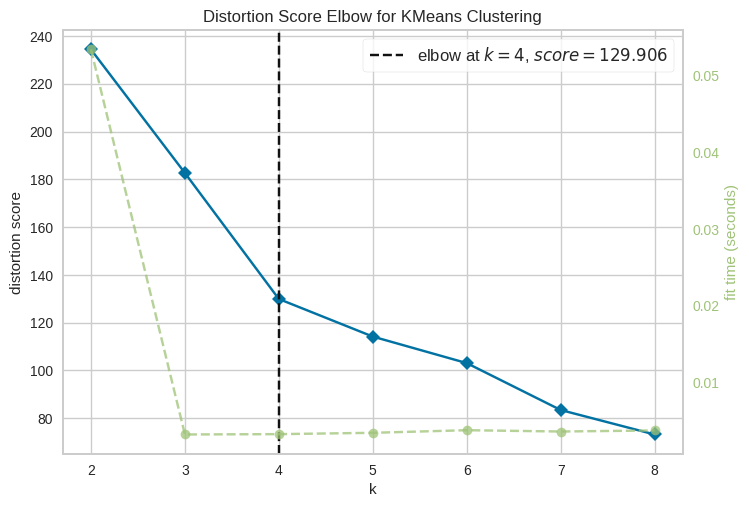

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
# Pastikan semua kolom di df_x adalah numerik
df_x_numeric = df_x.select_dtypes(include=['number'])

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 9))

visualizer.fit(df_x_numeric)
visualizer.show()

Based on the above plot we will segment the customers into 4 clusters, as the inertia value do not decrease much after 4 clusters

### Modeling cluster with kmeans function

In [26]:
#create model
model = KMeans(n_clusters=4, init='k-means++', random_state=123).fit(df_x)
model

KMeans(n_clusters=4, random_state=123)

In [27]:
preds = model.predict(df_x)
preds

array([3, 0, 3, 0, 1, 0, 1, 0, 1, 3, 1, 0, 1, 0, 1, 0, 1, 3, 1, 0, 1, 3,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 1, 0, 1, 0,
       1, 3, 1, 3, 3, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 1, 0, 3, 0, 0, 0, 3,
       1, 1, 3, 1, 0, 1, 1, 0, 1, 3, 0, 1, 3, 1, 0, 0, 1, 1, 3, 1, 0, 3,
       0, 1, 0, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 0, 3, 0, 3, 1, 1, 1, 1,
       0, 3, 1, 3, 3, 3, 1, 0, 1, 0, 3, 1, 0, 0, 3, 0, 1, 0, 1, 0, 1, 0,
       3, 0, 3, 0, 1, 0, 3, 0, 1, 0, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0], dtype=int32)

In [28]:
customer_kmeans = df_x.copy()
customer_kmeans['clusters'] = preds
customer_kmeans

,Gender,Age_Group,Income_Group,Spending_Score,clusters
0,1,1,1,2,3
1,1,2,1,4,0
2,0,1,1,1,3
3,0,2,1,4,0
4,0,3,1,2,1
...,...,...,...,...,...
195,0,3,4,4,0
196,0,4,4,2,2
197,1,3,4,3,0
198,1,3,4,1,2


In [29]:
centers = model.cluster_centers_
centers

array([[0.44594595, 2.89189189, 2.2027027 , 3.5       ],
       [0.39344262, 3.7704918 , 1.52459016, 1.80327869],
       [0.51851852, 3.55555556, 3.14814815, 1.25925926],
       [0.44736842, 1.55263158, 1.71052632, 2.44736842]])

In [30]:
customer_kmeans

,Gender,Age_Group,Income_Group,Spending_Score,clusters
0,1,1,1,2,3
1,1,2,1,4,0
2,0,1,1,1,3
3,0,2,1,4,0
4,0,3,1,2,1
...,...,...,...,...,...
195,0,3,4,4,0
196,0,4,4,2,2
197,1,3,4,3,0
198,1,3,4,1,2


### Cluster Identification

In [31]:
clusters = customer_kmeans.clusters.value_counts()

fig = px.pie(clusters,
             names = clusters.index,
             values = clusters.values,
             color_discrete_sequence= px.colors.qualitative.Vivid)
fig.update_traces(textposition='inside', textinfo='percent+label',
                  marker= dict(line = dict(color='white', width=2)))
fig.show()

- Most customers are grouped in Cluster 0 and Cluster 1 based on the clustering result.

In [32]:
df['clusters'] = customer_kmeans.clusters

In [33]:
display(df)

,CustomerID,Gender,Age,Annual_Income(k$),Spending_Score(1-100),Age_Group,Income_Group,Spending_Score,clusters
0,1,Male,19,15,39,18-20,"15k-<45,5k",26-50,3
1,2,Male,21,15,81,21-30,"15k-<45,5k",76-100,0
2,3,Female,20,16,6,18-20,"15k-<45,5k",0-25,3
3,4,Female,23,16,77,21-30,"15k-<45,5k",76-100,0
4,5,Female,31,17,40,31-40,"15k-<45,5k",26-50,1
...,...,...,...,...,...,...,...,...,...
195,196,Female,35,120,79,31-40,"106,5k-137k",76-100,0
196,197,Female,45,126,28,above 41,"106,5k-137k",26-50,2
197,198,Male,32,126,74,31-40,"106,5k-137k",51-75,0
198,199,Male,32,137,18,31-40,"106,5k-137k",0-25,2


### Cluster Identification

In [34]:
#age vs Clusters
age_cluster = df.groupby(['clusters', 'Age_Group'], observed=True).size().reset_index(name='Counts')

fig = px.bar(age_cluster, x='clusters', y='Counts', color='Age_Group',
             barmode='group', labels={'Counts': 'Counts'}, title='Age per Cluster',
             color_discrete_sequence= px.colors.qualitative.Vivid)
fig.update_layout(xaxis_title='Cluster', yaxis_title='Counts')
fig.show()

Cluster identifications:
- Cluster 0 -> Mid to older age (mostly 31–40)
- Cluster 1 -> Older age (mostly above 41)
- Cluster 2 -> Older age (mostly above 41)
- Cluster 3 -> Younger to mid age (18-30)

In [35]:
#income vs Clusters
income_cluster = df.groupby(['clusters', 'Income_Group'], observed=True).size().reset_index(name='Counts')

fig = px.bar(income_cluster, x='clusters', y='Counts', color='Income_Group',
             barmode='group', labels={'Counts': 'Counts'}, title='Income per Cluster',
             color_discrete_sequence= px.colors.qualitative.Vivid)
fig.update_layout(xaxis_title='Cluster', yaxis_title='Counts')
fig.show()

Cluster identifications:
- Cluster 0 -> Mid to older age (mostly 31–40), varied income
- Cluster 1 -> Older age (mostly above 41), lower-mid income
- Cluster 2 -> Older age (mostly above 41), upper to high income
- Cluster 3 -> Younger to mid age (18-30), lower-mid income

In [36]:
# Gender vs Clusters
gender_cluster = df.groupby(['clusters', 'Gender'], observed=True).size().reset_index(name='Counts')

fig = px.bar(gender_cluster, x='clusters', y='Counts', color='Gender',
             barmode='group', labels={'Counts': 'Counts'}, title='Gender per Cluster',
             color_discrete_sequence= px.colors.qualitative.Vivid)
fig.update_layout(xaxis_title='Cluster', yaxis_title='Counts')
fig.show()

Cluster identifications:
- Cluster 0 -> Mid to older age (mostly 31–40), varied income, mostly female
- Cluster 1 -> Older age (mostly above 41), lower-mid income, mostly female
- Cluster 2 -> Older age (mostly above 41), upper to high income, balanced gender
- Cluster 3 -> Younger to mid age (18-30), lower-mid income, mostly female

In [37]:
# Spending Score vs Clusters
spending_cluster = df.groupby(['clusters', 'Spending_Score'], observed=True).size().reset_index(name='Counts')

fig = px.bar(spending_cluster, x='clusters', y='Counts', color='Spending_Score',
             barmode='group', labels={'Counts': 'Counts'}, title='Spending Score per Cluster',
             color_discrete_sequence= px.colors.qualitative.Vivid)
fig.update_layout(xaxis_title='Cluster', yaxis_title='Counts')
fig.show()

Cluster identifications:
- Cluster 0 -> Mid to older age (mostly 31–40), varied income, mostly female, high spender
- Cluster 1 -> Older age (mostly above 41), lower-mid income, mostly female, moderate spender
- Cluster 2 -> Older age (mostly above 41), upper to high income, balanced gender, low spender
- Cluster 3 -> Younger to mid age (18-30), lower-mid income, mostly female, moderate to high spender

In [38]:
df['clusters_name'] = customer_kmeans.clusters
customer_kmeans.clusters = customer_kmeans.clusters.replace({0: 'Confident Spenders',
                                                             1: 'Moderate Spenders',
                                                             2: 'Wealthy Minimalists',
                                                             3: 'Young Actives'})
df['clusters_name'] = customer_kmeans.clusters

In [39]:
df

,CustomerID,Gender,Age,Annual_Income(k$),Spending_Score(1-100),Age_Group,Income_Group,Spending_Score,clusters,clusters_name
0,1,Male,19,15,39,18-20,"15k-<45,5k",26-50,3,Young Actives
1,2,Male,21,15,81,21-30,"15k-<45,5k",76-100,0,Confident Spenders
2,3,Female,20,16,6,18-20,"15k-<45,5k",0-25,3,Young Actives
3,4,Female,23,16,77,21-30,"15k-<45,5k",76-100,0,Confident Spenders
4,5,Female,31,17,40,31-40,"15k-<45,5k",26-50,1,Moderate Spenders
...,...,...,...,...,...,...,...,...,...,...
195,196,Female,35,120,79,31-40,"106,5k-137k",76-100,0,Confident Spenders
196,197,Female,45,126,28,above 41,"106,5k-137k",26-50,2,Wealthy Minimalists
197,198,Male,32,126,74,31-40,"106,5k-137k",51-75,0,Confident Spenders
198,199,Male,32,137,18,31-40,"106,5k-137k",0-25,2,Wealthy Minimalists


In [40]:
clusters_name = df.clusters_name.value_counts()

fig = px.pie(clusters_name,
             names=clusters_name.index,
             values=clusters_name.values,
             color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_traces(textposition='auto', textinfo='percent',
                  marker=dict(line=dict(color='white', width=2)))
fig.show()

Insights: most of our customer are confident and moderate spender, about 37% and 30,5%.

For long-term focus:
- Confident Spenders (Cluster 0): With high spending and frequent purchases, they are ideal for loyalty programs or exclusive offers, encouraging repeat business.
- Moderate Spenders (Cluster 1): Though moderate spenders, they are stable and loyal. Offering functional, durable products with great value can foster long-term relationships.

In [41]:
def tsne_simple(dataframe, feature_matrix):
    tsne = TSNE(n_components=2)
    colors = ['#48D1CC', '#9ACD32', '#CD5C5C','#CD853F','#FFC0CB','#BC8F8F','#DDA0DD','#E5CF9C']
    mycolors = np.array([color for color in colors])
    tsne_result = tsne.fit_transform(feature_matrix)
    plt.scatter(tsne_result[:,0], tsne_result[:,1], color=mycolors[dataframe['clusters']])
    plt.title('Cluster Distribution(t-SNE) ')
    plt.show()

In [42]:
df_x['clusters'] = df.clusters
df_x

,Gender,Age_Group,Income_Group,Spending_Score,clusters
0,1,1,1,2,3
1,1,2,1,4,0
2,0,1,1,1,3
3,0,2,1,4,0
4,0,3,1,2,1
...,...,...,...,...,...
195,0,3,4,4,0
196,0,4,4,2,2
197,1,3,4,3,0
198,1,3,4,1,2


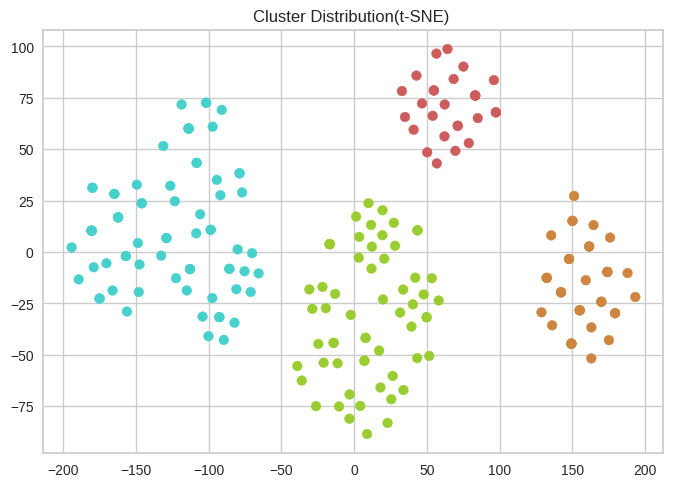

In [43]:
#displaying simple tsne and pca
tsne_simple(df_x.copy(), df_x)

In [44]:
def tsne(dataframe, number_of_cluster, feature_matrix):
    # perform t-SNE to obtain 2D representation of the data
    tsne = TSNE(n_components=2, random_state=0)
    tsne_matrix = tsne.fit_transform(feature_matrix)

    colors = ['#48D1CC', '#9ACD32', '#CD5C5C', '#CD853F', '#FFC0CB', '#BC8F8F', '#DDA0DD', '#E5CF9C']

    # create scatterplot of the data
    plt.figure(figsize=(6, 6), dpi=200)

    for i in range(number_of_cluster):
        cluster_points = dataframe['clusters'] == i
        plt.scatter(tsne_matrix[cluster_points, 0], tsne_matrix[cluster_points, 1], c=colors[i], label=f'Cluster {i}')

        # add annotations using Spending_Score
        spending_scores = dataframe[cluster_points]['Spending_Score'].values
        x_coords = tsne_matrix[cluster_points, 0]
        y_coords = tsne_matrix[cluster_points, 1]

        for j, score in enumerate(spending_scores):
            plt.annotate(str(score), (x_coords[j], y_coords[j]), fontsize=6)

    plt.title('Cluster Distribution (t-SNE)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.show()

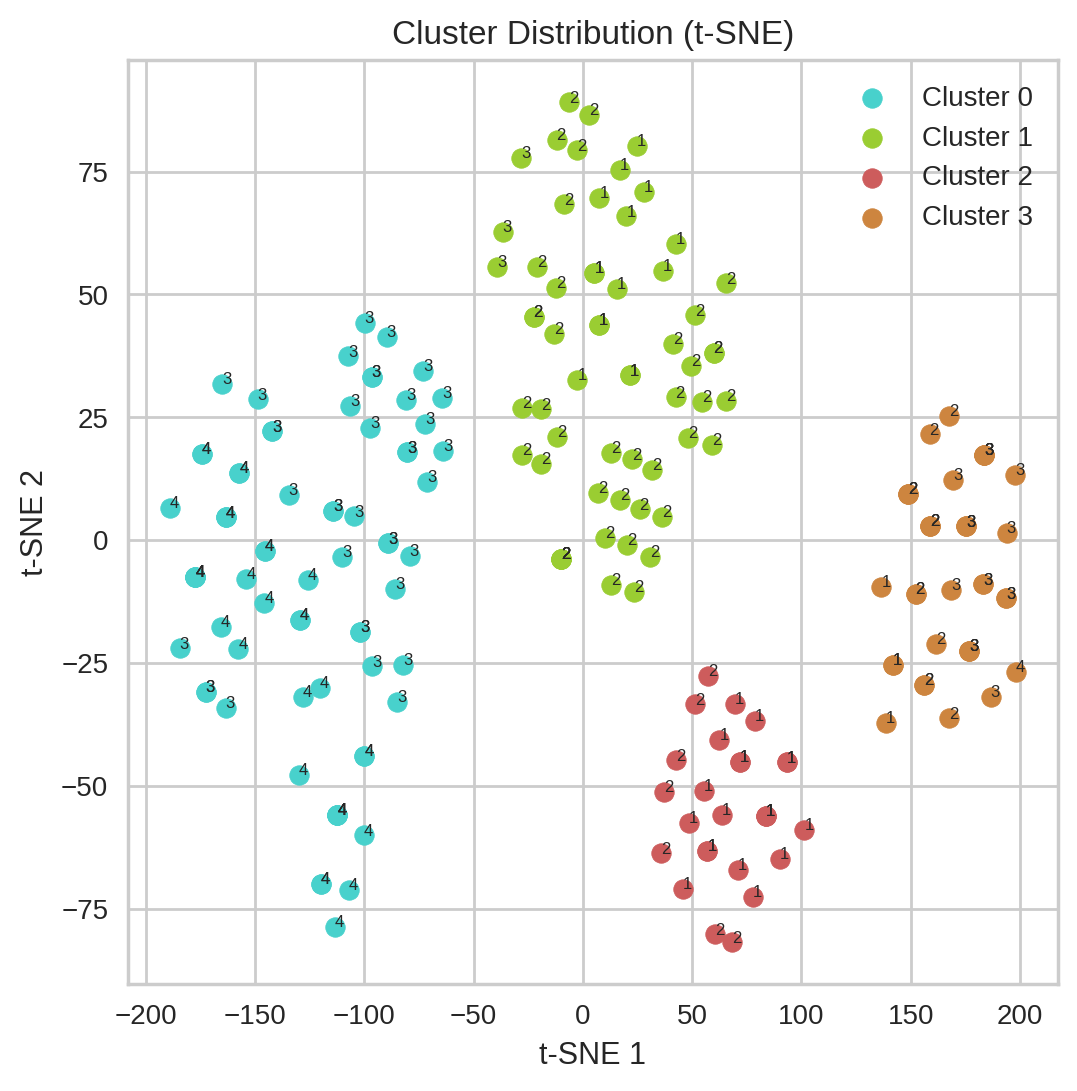

In [45]:
#displaying simple tsne and pca
tsne(df_x.copy(), 4, df_x)

Based on the t-SNE visualization, each cluster forms a distinct group, indicating that customer segments have unique characteristics.

- **Cluster 0** (Confident Spenders) and **Cluster 1** (Moderate Spenders) are located on the left side of the plot. They are relatively close to each other, indicating similarities in age range, but still form separate clusters, which may reflect differences in their spending capacity or other demographic factors.
- **Cluster 2** (Wealthy Minimalists) is the most clearly separated cluster in the plot. It is positioned at the lower-middle area, far from Cluster 0 and Cluster 1, suggesting that this group has significantly different spending behavior compared to the others.
- **Cluster 3** (Young Actives) forms a separate cluster on the right side of the plot. It is close to Cluster 2,  its distinct position reflects that younger customers have different spending patterns from older age groups.